In [1]:
#figuring out which GPU to use...
!nvidia-smi

Fri Apr  2 03:23:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 16%   33C    P8    11W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 16%   37C    P8    24W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "2"


In [3]:
%load_ext autoreload
%autoreload 2

from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.mock_observables.two_point_clustering import tpcf
from halotools.mock_observables import return_xyz_formatted_array

from tensorflow_probability import edward2 as ed

import diffhod

from diffhod.components import Zheng07Cens, Zheng07SatsRelaxedBernoulli, Zheng07SatsPoisson,NFWProfile

#from flowpm.utils import cic_paint
import tensorflow as tf

%pylab inline

batch mode...
Populating the interactive namespace from numpy and matplotlib


/home/ben.horowitz/miniconda3/envs/dhod2/lib/python3.8/site-packages/diffhod-0.1-py3.8.egg/diffhod/components.py:8: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.


In [4]:
tf.__version__

'2.2.0'

In [5]:
#TF2 compatable painter
@tf.function#(experimental_relax_shapes=True)
def cic_paint(mesh, part, weight=None, name="CiCPaint"):
  """
  Paints particules on a 3D mesh.
  Parameters:
  -----------
  mesh: tensor (batch_size, nc, nc, nc)
    Input 3D mesh tensor
  part: tensor (batch_size, npart, 3)
    List of 3D particle coordinates, assumed to be in mesh units if
    boxsize is None
  weight: tensor (batch_size, npart)
    List of weights  for each particle
  """
  with tf.name_scope(name):
    mesh = tf.convert_to_tensor(mesh, name="mesh")
    part = tf.convert_to_tensor(part, name="part")
    if weight is not None:
      weight = tf.convert_to_tensor(weight, name="weight")

    shape = tf.shape(mesh)
    batch_size, nx, ny, nz = shape[0], shape[1], shape[2], shape[3]
    nc = nz

    # Flatten part if it's not already done
    if len(part.shape) > 3:
      part = tf.reshape(part, (batch_size, -1, 3))

    # Extract the indices of all the mesh points affected by each particles
    part = tf.expand_dims(part, 2)
    floor = tf.floor(part)
    connection = tf.expand_dims(tf.constant([[[0, 0, 0], [1., 0, 0],[0., 1, 0],
                                              [0., 0, 1],[1., 1, 0],[1., 0, 1],
                                              [0., 1, 1],[1., 1, 1]]]), 0)

    neighboor_coords = floor + connection
    kernel = 1. - tf.abs(part - neighboor_coords)
    # Replacing the reduce_prod op by manual multiplication
    # TODO: figure out why reduce_prod was crashing the Hessian computation
    kernel = kernel[..., 0] * kernel[..., 1] * kernel[..., 2]

    if weight is not None: kernel = tf.multiply(tf.expand_dims(weight, axis=-1) , kernel)

    neighboor_coords = tf.cast(neighboor_coords, tf.int32)
    neighboor_coords = tf.math.mod(neighboor_coords , nc)

    # Adding batch dimension to the neighboor coordinates
    batch_idx = tf.range(0, batch_size)
    batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1, 1))
    b = tf.tile(batch_idx, [1] + list(neighboor_coords.get_shape()[1:-1]) + [1])
    neighboor_coords = tf.concat([b, neighboor_coords], axis=-1)

    update = tf.scatter_nd(tf.reshape(neighboor_coords, (-1, 8,4)),tf.reshape(kernel, (-1, 8)),[batch_size, nx, ny, nz])
    mesh = mesh + update
    return mesh


In [6]:
def _initialize_pk(shape,boxsize,kmin,dk):
    """
       Helper function to initialize various (fixed) values for powerspectra... not differentiable!
    """
    I = np.eye(len(shape), dtype='int') * -2 + 1

    W = np.empty(shape, dtype='f4')
    W[...] = 2.0
    W[..., 0] = 1.0
    W[..., -1] = 1.0
    kedges = np.arange(kmin, np.pi * 3 / 2 + dk/2, dk)

    k = [np.fft.fftfreq(N, 1. / (N * 4 * np.pi / L))[:pkshape].reshape(kshape) for N, L, kshape, pkshape in zip(shape, boxsize, I, shape)]
    kmag = sum(ki ** 2 for ki in k) ** 0.5

    xsum = np.zeros(len(kedges) + 1)
    Nsum = np.zeros(len(kedges) + 1)

    dig = np.digitize(kmag.flat, kedges)

    xsum.flat += np.bincount(dig, weights=(W * kmag).flat, minlength=xsum.size)
    Nsum.flat += np.bincount(dig, weights=W.flat, minlength=xsum.size)
    dig = tf.convert_to_tensor(dig,dtype=tf.int32)
    Nsum = tf.convert_to_tensor(Nsum,dtype=tf.complex64)
    xsum = tf.convert_to_tensor(np.array(xsum))
    W = tf.convert_to_tensor(np.array(W))
    k = np.array(k)
    kedges = tf.convert_to_tensor(np.array(kedges))
    return dig, Nsum, xsum, W,  kedges



In [7]:
#updated pk for batch mode...
dig, Nsum, xsum, W,  kedges = _initialize_pk(np.array([32,32,32]),np.array([64,64,64]),0.045,.049)

@tf.function
def pk(field,dig=dig, Nsum=Nsum, xsum=xsum, W=W,  kedges=kedges,kmin=5,dk=0.8):  
    print("traced!")
    """
    Calculate the powerspectra given real space field
    
    Args:
        
        field: real valued field 
        kmin: minimum k-value for binned powerspectra
        dk: differential in each kbin
        shape: shape of field to calculate field (can be strangely shaped?)
        boxsize: length of each boxlength (can be strangly shaped?)
    
    Returns:
        
        kbins: the central value of the bins for plotting
        power: real valued array of power in each bin
        
    """
     
    bs = field.shape[0] #batch size
    #print(np.sum(bs))
    #dig, Nsum, xsum, W, k, kedges = _initialize_pk(shape,boxsize,kmin,dk)

    #convert field to complex for fft
    field_complex = tf.dtypes.cast(field,dtype=tf.complex64)

    #fast fourier transform
    fft_image = tf.map_fn(tf.signal.fft3d, field_complex)#, dtype=None, parallel_iterations=None, back_prop=True,
    #swap_memory=False, infer_shape=True, name=None
    #)


    #absolute value of fast fourier transform
    pk = tf.math.real(fft_image*tf.math.conj(fft_image))
    #calculating powerspectra
    Psum = tf.zeros(tf.size(kedges) + 1, dtype=tf.complex64)
    real = tf.reshape(tf.math.real(pk),[bs,-1,])
    imag = tf.reshape(tf.math.imag(pk),[bs,-1,])


    #def bincount func
    @tf.function
    def bincount(x):
        return tf.math.bincount(dig, weights=(tf.reshape(W,[-1])  * x), minlength=tf.size(xsum))
    #Psum1 = tf.dtypes.cast(tf.vectorized_map(bincount, imag),dtype=tf.complex64)*1j
    #Psum2 = tf.dtypes.cast(tf.vectorized_map(bincount, real),dtype=tf.complex64)
    Psum1 = tf.dtypes.cast(tf.map_fn(
     bincount, imag, dtype=None, parallel_iterations=None, back_prop=True,
     swap_memory=False, infer_shape=True, name=None
     ),dtype=tf.complex64)*1j

    Psum2 = tf.dtypes.cast(tf.map_fn(
     bincount, real, dtype=None, parallel_iterations=None, back_prop=True,
     swap_memory=False, infer_shape=True, name=None
     ),dtype=tf.complex64)


    power = ((Psum + Psum1+Psum2)/ Nsum)[:,1:-1]* tf.cast(64**3,dtype=complex64)

    #normalization for powerspectra
    norm = tf.dtypes.cast(32**3,dtype=tf.float32)**2

    #find central values of each bin
    kbins = kedges[:-1]+ (kedges[1:] - kedges[:-1])/2

    return kbins,tf.dtypes.cast(power,dtype=tf.float32)/norm

<ipython-input-6-485e7905a0ba>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5
<ipython-input-6-485e7905a0ba>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  k = np.array(k)


In [8]:
# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=0.) 

# Removing subhalos and convert table to tensors
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]
halo_table = halo_table[halo_table['halo_x'] < 128]
halo_table = halo_table[halo_table['halo_y'] < 128]
halo_table = halo_table[halo_table['halo_z'] < 128]

tf_halocat = {k: tf.stop_gradient(tf.convert_to_tensor(halo_table[k], dtype=tf.float32)) for k in halo_table.colnames}



In [9]:
# We first load our reference halotools model
zheng07_model = PrebuiltHodModelFactory('zheng07', redshift =-0, 
                                        modulate_with_cenocc=True)

In [10]:
# Let's see what are the parameters of the model
zheng07_model.param_dict

{'logMmin': 12.02,
 'sigma_logM': 0.26,
 'logM0': 11.38,
 'logM1': 13.31,
 'alpha': 1.06}

In [11]:
zheng07_model.populate_mock(halocat)

In [12]:
# Here is how we define the same model in diffhod
@tf.function
def hod(halo_cat, logMmin, sigma_logM, logM0, logM1, alpha, max_sat=34, temp=0.01,bs=10):
  ### Occupation model ###
  n_cen = Zheng07Cens(halo_cat['halo_mvir'],
                      sigma_logM=sigma_logM,
                      logMmin=logMmin,
                      temperature=temp)
  n_sat = Zheng07SatsRelaxedBernoulli(halo_cat['halo_mvir'],
                                      n_cen,
                                      logM0=logM0,
                                      logM1=logM1,
                                      alpha=alpha,
                                      sample_shape=(max_sat,),
                                      temperature=temp)
  
  ### Phase Space model ###
  # Centrals are just located at center of halo
  pos_cen = ed.Deterministic(tf.stack([halo_cat['halo_x'],
                                        halo_cat['halo_y'],
                                        halo_cat['halo_z']], axis=-1))

  # Satellites follow an NFW profile centered on halos
  pos_sat = NFWProfile(pos=pos_cen,
                        concentration=halo_cat['halo_nfw_conc'],
                        Rvir=halo_cat['halo_rvir'],
                        sample_shape=(max_sat,))
  
  return {'pos_cen':pos_cen,'n_cen':n_cen, 'pos_sat':pos_sat,  'n_sat':n_sat}

In [13]:
#batch compatable painter
@tf.function
def paint_galaxies(gal_cat, nc=64):
    # Take centrals and rescale them to the boxsize
    
    bs = gal_cat['n_sat'].shape[1]
    
    sample1 = gal_cat['pos_cen'] / 32. * nc
    weights1 = gal_cat['n_cen']
    # Take sats and rescale them to the boxize
  
    sample2 = tf.reshape(gal_cat['pos_sat'], [-1,3]) / 32. * nc
    weights2 = tf.reshape(gal_cat['n_sat'],[bs,-1])
    
    sample1_r = tf.tile(tf.expand_dims(sample1,0),[bs,1,1])
    print(sample1_r.shape,weights1.shape)
    rho1 = cic_paint(tf.zeros((bs, nc, nc, nc)),sample1_r, weights1)
    sample2_r = tf.tile(tf.expand_dims(sample2,0),[bs,1,1])
    print(sample2_r.shape,weights2.shape)

    rho2 = cic_paint(tf.zeros((bs, nc, nc, nc)),sample2_r, weights2)
    rho = rho1+rho2
    return rho

In [14]:
# sampling galaxies from the model, with given params
@tf.function
def sample(halo_cat, logMmin, sigma_logM, logM0, logM1, alpha):
    return paint_galaxies(hod(halo_cat,logMmin, sigma_logM, logM0, logM1, alpha))

In [15]:
#check all variables for batch-ness

rho = sample(tf_halocat,tf.Variable([15.02,11.0,10.02]), tf.Variable([0.26,0.22,0.40]), tf.Variable([10.0,11.,13.0]), tf.Variable([10.31,12.0,13.0]), tf.Variable([1.06,1.06,1.06]))
                                                                                                     
np.save("rho",rho)                                                                                        

Tensor("Pow:0", shape=(3,), dtype=float32)
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
(3, 139905, 3) (3, 139905)
(3, 4756770, 3) (3, 4756770)


In [16]:
dig, Nsum, xsum, W,  kedges = _initialize_pk(np.array([64,64,64]),np.array([128,128,128]),0.045,.049)

k2, pkr2 = pk(rho, tf.constant(dig), tf.constant(Nsum), tf.constant(xsum), tf.constant(W),  tf.constant(kedges),
         kmin=tf.constant(0.045),dk=tf.constant(.049))

<ipython-input-6-485e7905a0ba>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5
<ipython-input-6-485e7905a0ba>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  k = np.array(k)


traced!


In [17]:
pkr2,k2

(<tf.Tensor: shape=(3, 95), dtype=float32, numpy=
 array([[           nan, 9.20492096e+01, 1.15071877e+02, 4.29729919e+01,
         3.43784599e+01, 3.85165634e+01, 3.62604904e+01, 2.72770672e+01,
         3.19876080e+01, 2.57034359e+01, 2.28798485e+01, 1.97900925e+01,
         2.18934193e+01, 2.10158405e+01, 1.94413700e+01, 1.89628563e+01,
         2.04496784e+01, 1.89376163e+01, 1.89026127e+01, 1.72370567e+01,
         1.65822353e+01, 1.49961500e+01, 1.53626766e+01, 1.51135511e+01,
         1.34376926e+01, 1.31571198e+01, 1.25608730e+01, 1.15571947e+01,
         1.10134106e+01, 1.07575989e+01, 1.00270519e+01, 1.04231052e+01,
         8.79076099e+00, 9.09640408e+00, 8.77541542e+00, 7.98340082e+00,
         7.77860546e+00, 7.15563679e+00, 7.16990423e+00, 6.40568161e+00,
         6.30154848e+00, 6.32531309e+00, 5.91827536e+00, 5.56289053e+00,
         5.29659605e+00, 4.84156370e+00, 4.41869926e+00, 4.48385906e+00,
         4.07686138e+00, 4.04239130e+00, 3.75288534e+00, 3.55471206e+00,
 

## Stuff from Chang

In [18]:
k_ht = np.load("k_arr.npy")

In [19]:
pk_ht = np.load("pk_fid.100.npy")

In [20]:
rho[0].shape

TensorShape([64, 64, 64])

In [21]:
#fiducial model
rho = sample(tf_halocat,12.02, 0.26, 11.38, 13.31, 01.006)

Tensor("Pow:0", shape=(), dtype=float32)
(1, 139905, 3) (1, 139905)
(1, 4756770, 3) (1, 4756770)


In [22]:
for i in range(19):
    print(k2[i]-k_ht[i])

tf.Tensor(-2.844818051044029e-05, shape=(), dtype=float64)
tf.Tensor(-0.0017603547523419028, shape=(), dtype=float64)
tf.Tensor(-0.0008630323723742839, shape=(), dtype=float64)
tf.Tensor(-0.001672585715850189, shape=(), dtype=float64)
tf.Tensor(-0.0035855235588260204, shape=(), dtype=float64)
tf.Tensor(-0.003248258265938775, shape=(), dtype=float64)
tf.Tensor(-0.002536991999801952, shape=(), dtype=float64)
tf.Tensor(-0.002452970683165523, shape=(), dtype=float64)
tf.Tensor(-0.0032724668763271514, shape=(), dtype=float64)
tf.Tensor(-0.003484447550878955, shape=(), dtype=float64)
tf.Tensor(-0.0029180744788155355, shape=(), dtype=float64)
tf.Tensor(-0.004133227309564114, shape=(), dtype=float64)
tf.Tensor(-0.005289863373809989, shape=(), dtype=float64)
tf.Tensor(-0.005608969823777898, shape=(), dtype=float64)
tf.Tensor(-0.004925108420476776, shape=(), dtype=float64)
tf.Tensor(-0.003955850011196693, shape=(), dtype=float64)
tf.Tensor(-0.004069847597366727, shape=(), dtype=float64)
tf.Tenso

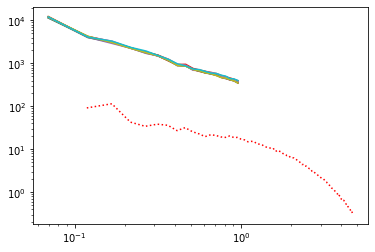

In [23]:
for i in range(0,10):
    plt.loglog(k_ht,pk_ht[i][:19])

plt.loglog(k2,pkr2[0],"r:")


In [24]:
bs=10
#rho = sample(tf_halocat, 12.02*tf.ones(bs,dtype=float32), 0.26*tf.ones(bs,dtype=float32), 11.38*tf.ones(bs,dtype=float32), 13.31*tf.ones(bs,dtype=float32), 1.06*tf.ones(bs,dtype=float32) )

@tf.function
def get_pk(tf_halocat):
   # tf.stop_gradient(tf_halocat)
    rho = sample(tf_halocat, 12.02*tf.ones(bs,dtype=float32), 0.26*tf.ones(bs,dtype=float32), 11.38*tf.ones(bs,dtype=float32), 13.31*tf.ones(bs,dtype=float32), 1.06*tf.ones(bs,dtype=float32))
    print(rho.shape)
    k2, pkr = pk(rho, dig=tf.constant(dig), Nsum=tf.constant(Nsum), xsum=tf.constant(xsum), W=tf.constant(W),  kedges=tf.constant(kedges),

         kmin=tf.constant(0.045),dk=tf.constant(.049))
    
    
   # pk(sample(tf_halocat, 12.02*np.ones(bs,dtype=float32), 0.26*np.ones(bs,dtype=float32), 11.38*np.ones(bs,dtype=float32), 13.31*np.ones(bs,dtype=float32), 1.06*np.ones(bs,dtype=float32) ),
   #      shape=rho[0].shape, 
    #     boxsize = np.array([64,64,64]), 
    #     kmin=0.045,dk=.049)
    print(pkr.shape)
    return pkr*300


In [25]:
cov_pk = np.cov(pk_ht.T)
cinv_pk = np.linalg.inv(cov_pk)

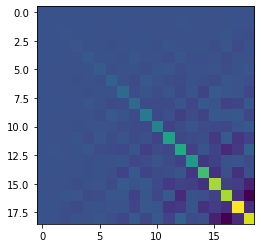

In [26]:
imshow(cinv_pk)

In [27]:
pk_obs = np.mean(pk_ht, axis=0) # our "observed P(k)"

In [28]:
# Ok sweet, so now we can define these as a function of variables
logM = tf.Variable(12.5)
sig_logM = tf.Variable(0.5)
logM0 = tf.Variable(11.38)
logM1 = tf.Variable(13.01)
alpha = tf.Variable(1.6)

In [29]:
@tf.function
def batch_func(x,avg_samp=1):
    #for each set of parameters, we average over avg_samp runs
        X = sample(tf_halocat, np.ones(avg_samp,dtype=np.float32)*x[0], np.ones(avg_samp,dtype=np.float32)*x[1], np.ones(avg_samp,dtype=np.float32)*x[2], np.ones(avg_samp,dtype=np.float32)*x[3], np.ones(avg_samp,dtype=np.float32)*x[4])
        _, pkr = pk(X,#sample(tf_halocat, X[:,0], X[:,1], 11.38, X[:,2], X[:,3]),
                 tf.constant(dig), tf.constant(Nsum), tf.constant(xsum), tf.constant(W),  tf.constant(kedges),
        kmin=tf.constant(0.045),dk=tf.constant(.049))
        return tf.reduce_mean(pkr*40,axis=0)[1:19]

In [30]:
#testing to make sure it runs...
batch_func(np.array([12.0,1.01,11.38,13.01, 0.20],dtype=np.float32))

Tensor("Pow:0", shape=(1,), dtype=float32)
traced!


<tf.Tensor: shape=(18,), dtype=float32, numpy=
array([4269.1377 , 4289.339  , 1434.2361 , 1358.4252 , 1004.86664,
        992.53076,  835.2402 ,  624.7465 ,  576.6486 ,  582.142  ,
        459.6829 ,  536.52277,  446.33298,  472.5808 ,  400.25558,
        468.2999 ,  384.8891 ,  418.4074 ], dtype=float32)>

In [31]:
@tf.function
def loss(X):
    pkr = tf.map_fn(batch_func,X)
    print(pkr.shape)
    return tf.reduce_sum(-1/19*1/2*1/8*((pk_obs[1:20] - pkr)**2.0*np.diag(cinv_pk)[1:19]),axis=1)
   # return tf.reduce_sum(-1*(pkr - pkr2) @ (inv_covar) @ tf.transpose(pkr - pkr2),axis=1)


In [32]:
{'logMmin': 12.02,
 'sigma_logM': 0.26,
 'logM0': 11.38,
 'logM1': 13.31,
 'alpha': 1.06}

{'logMmin': 12.02,
 'sigma_logM': 0.26,
 'logM0': 11.38,
 'logM1': 13.31,
 'alpha': 1.06}

In [33]:
#checking loss function
X_test = tf.Variable(np.array([[12.02, 01.56, 11.38, 13.31, 001.06],[12.02, 0.26, 11.38, 13.31, 01.06]],dtype=float32),dtype=float32)

output = loss(X_test)

print(output)



(2, 18)
tf.Tensor([ -8.684457 -69.27387 ], shape=(2,), dtype=float32)


# Check Gradients...

alpha_list = np.linspace(0.99,1.01,50,dtype=float32)
loss_ar = []
grad_ar = []
for i in alpha_list:
    logM = tf.Variable([12.5])
    sig_logM = tf.Variable([0.25])
    logM0 = tf.Variable([11.38])
    logM1 = tf.Variable([13.01])
    x = tf.Variable([01.01])
    #X = tf.transpose(tf.stack([logM,sig_logM,logM0,logM1, x]))
    X = tf.transpose(tf.stack([logM,sig_logM,logM0,logM1, x]))
    print(X)
    L = loss(X)
    print(L)
    loss_ar.append(np.array(L))
    def get_grads(x):
        with tf.GradientTape(persistent=True) as g:
          # g.watch(x)
           X = tf.transpose(tf.stack([logM,sig_logM,logM0,logM1, x]))
           print(X)
           L = loss(X)
        dL_dx = g.gradient(L, x)
        return dL_dx
    #a = tf.constant((np.array([[12.5,0.5,11.38,13.01, x]],dtype=np.float32)))
    grad = get_grads(x)
    grad_ar.append(np.array(grad))

In [ ]:
logM = tf.Variable([11.5])
sig_logM = tf.Variable([0.25])
logM0 = tf.Variable([11.38])
logM1 = tf.Variable([12.31])
x = tf.Variable([0001.0900001])
#y = tf.Variable([00000001.99900001])

#X = tf.transpose(tf.stack([logM,sig_logM,logM0,logM1, x]))
X = tf.transpose(tf.stack([logM,sig_logM,logM0,logM1, x]))
print(X)
L = loss(X)
print(L)
#loss_ar.append(np.array(L))
def get_grads(x):
    with tf.GradientTape(persistent=True) as g:
       g.watch(x)
       X = tf.transpose(tf.stack([logM,sig_logM,logM0,logM1, x]))
       print(X)
       L = sample(tf_halocat,logM,sig_logM,logM0,logM1, x)#loss(X)
    dL_dx = g.gradient(L, x)
    return dL_dx
#a = tf.constant((np.array([[12.5,0.5,11.38,13.01, x]],dtype=np.float32)))
grad = get_grads(x)
print(grad)

tf.Tensor([[11.5        0.25      11.38      12.31       1.0900002]], shape=(1, 5), dtype=float32)
tf.Tensor([-5135.9023], shape=(1,), dtype=float32)
tf.Tensor([[11.5        0.25      11.38      12.31       1.0900002]], shape=(1, 5), dtype=float32)
Tensor("Pow:0", shape=(1,), dtype=float32)


In [38]:
plt.plot(alpha_list,grad_ar)
plt.plot(alpha_list,loss_ar)

NameError: name 'alpha_list' is not defined

# HMC Stuff, ignore for now...

In [39]:
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tf.enable_v2_behavior()

num_burnin_steps = int(3e0) #oops....
num_chains = 5


adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=loss,
        num_leapfrog_steps=3,
        step_size=.030), #can play a lot with this number...
    num_adaptation_steps=int(num_burnin_steps * 0.8))


In [40]:
#start spread out around some point
var = (np.random.random([num_chains, 5])-0.5)*np.array([0.1,0.02,0.01,0.1,0.01])*0.010

In [41]:

num_results = 100

# Initial state of the chain
init_state = tf.Variable(np.ones([num_chains, 5], dtype=dtype)*np.array([12.12, 0.36, 11.36, 13.21, 0001.00],dtype=float32)+var,dtype=float32)

@tf.function
def run_chain():
  # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=init_state,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

    return samples,is_accepted#sample_mean, sample_stddev, is_accepted


In [42]:
init_state

<tf.Variable 'Variable:0' shape=(5, 5) dtype=float32, numpy=
array([[12.120124  ,  0.3600341 , 11.359966  , 13.210397  ,  1.0000131 ],
       [12.120217  ,  0.36000857, 11.36003   , 13.210456  ,  0.99995434],
       [12.119914  ,  0.36009854, 11.360018  , 13.2102165 ,  0.99997264],
       [12.119939  ,  0.35997558, 11.360001  , 13.209677  ,  1.0000205 ],
       [12.119958  ,  0.3599298 , 11.359952  , 13.210005  ,  0.99995106]],
      dtype=float32)>

In [43]:
import time
current_time = time.time()
q,is_accepted = run_chain()
run_time = time.time()-current_time
print(run_time)

(5, 18)
929.9023239612579


In [44]:
#time in hours, since math is hard
print(run_time/60/60)

0.25830620110034946


In [45]:
#make sure chain moved...
q[0],q[0]-q[-1]



(<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
 array([[12.120124  ,  0.3600341 , 11.359966  , 13.210397  ,  1.0000131 ],
        [12.120217  ,  0.36000857, 11.36003   , 13.210456  ,  0.99995434],
        [12.119914  ,  0.36009854, 11.360018  , 13.2102165 ,  0.99997264],
        [12.119939  ,  0.35997558, 11.360001  , 13.209677  ,  1.0000205 ],
        [12.119958  ,  0.3599298 , 11.359952  , 13.210005  ,  0.99995106]],
       dtype=float32)>,
 <tf.Tensor: shape=(5, 5), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], dtype=float32)>)

In [46]:
loss(q[0])

(5, 18)


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-88.0327  , -82.2862  , -85.444565, -82.585655, -81.534805],
      dtype=float32)>

(array([200.,   0.,   0., 100.,   0.,   0.,   0.,   0., 100., 100.]),
 array([0.99995106, 0.99995804, 0.99996495, 0.99997187, 0.99997884,
        0.9999858 , 0.9999927 , 0.99999964, 1.0000067 , 1.0000136 ,
        1.0000205 ], dtype=float32),
 <a list of 10 Patch objects>)

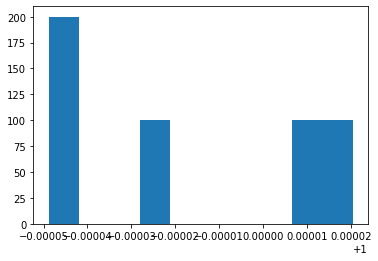

In [47]:
plt.hist(np.array(q).reshape(-1,5)[:,-1])

In [48]:
import corner

In [49]:
q.shape

TensorShape([100, 5, 5])

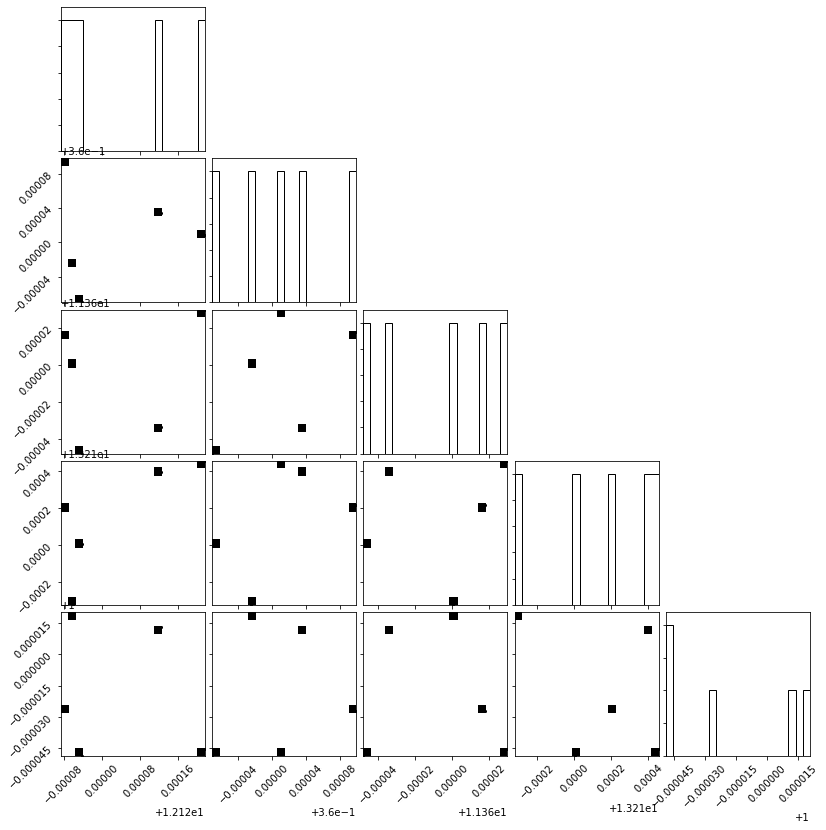

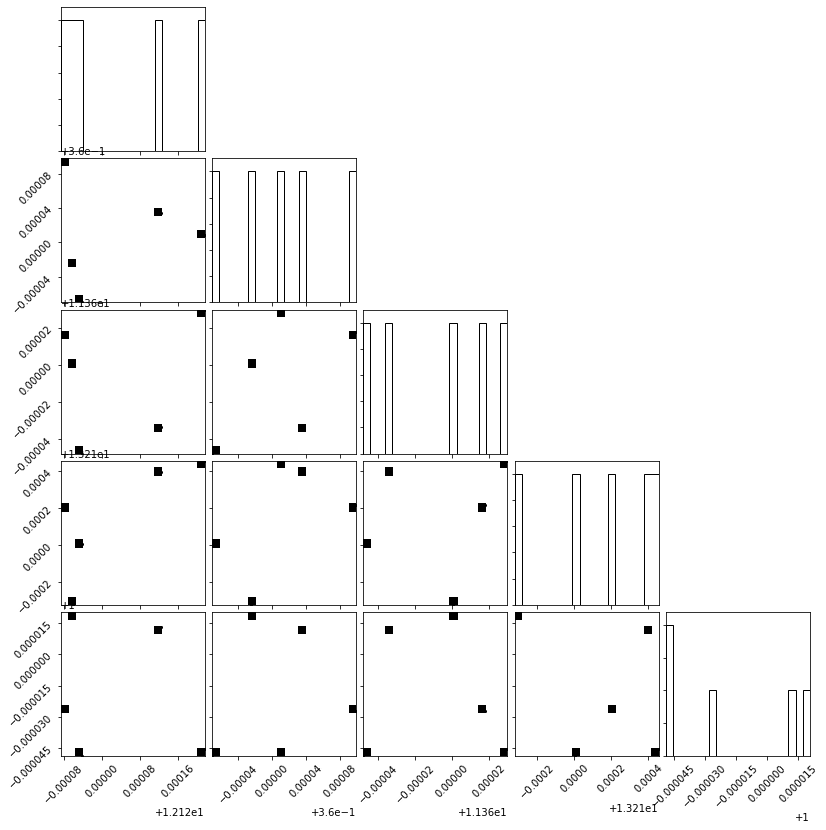

In [56]:
corner.corner(np.array(q[:,:,:]).reshape(-1,5)[:],smooth=0.300)

In [55]:
q.shape

TensorShape([100, 5, 5])

In [52]:
#logMmin, sigma_logM, logM1, alpha

In [53]:
q.shape

TensorShape([100, 5, 5])

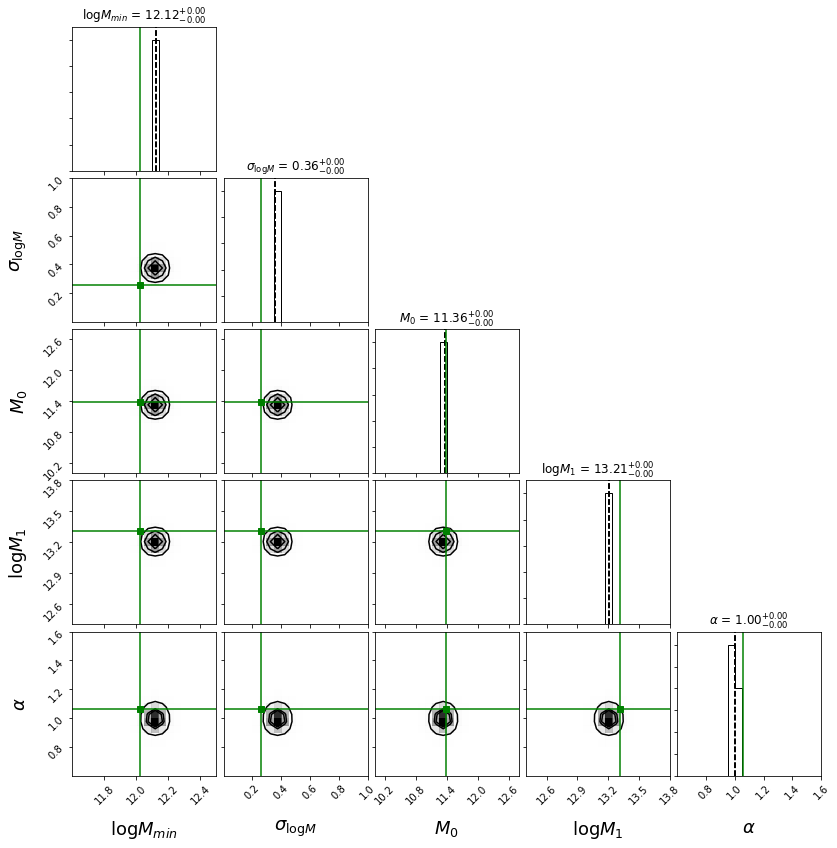

In [54]:
value1 = [12.02, 0.26, 11.38,13.31, 1.06]
#range=[(11.5,12.4),(0.00,0.60),(13.1,14.1),(0.950,1.3)]
levels = 1.0 - np.exp(-0.5 * np.arange(0.5, 2.1, 0.5) ** 2)
figure = corner.corner(np.array(q)[:,:].reshape(-1,5),labels = [r"$\log M_{min}$", r"$\sigma_{\log M}$", r"$M_0$",r"$\log M_1$", r"$\alpha$"],label_kwargs={"fontsize":18} ,
                       quantiles=[0.16, 0.5, 0.84],levels=levels,show_titles=True,
                       smooth=1.0,plot_datapoints=True,range=[[11.6,12.5],[0.0,1.0],[10,12.8],[12.4,13.8],[0.60,1.6]])
ndim = 5
# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i], color="g")

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="g")
        ax.axhline(value1[yi], color="g")
        ax.plot(value1[xi], value1[yi], "sg")
plt.savefig("HMC_Output.pdf")



In [ ]:
plt.hist(np.array(q[::10,:,-1]).flatten())

In [ ]:
#could run for longer and probably get better curves...

In [ ]:
#np.save("HMC_Output_031520", np.array(q))